In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import random
import datetime
import re
import warnings

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from IPython.display import Image
from mlxtend.plotting import heatmap, plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, KFold, RepeatedKFold
from sklearn.metrics import r2_score

# XGBoost
import xgboost as xgb

# TensorFlow
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import initializers

# SciPy
import scipy.stats as stats
from scipy.stats import uniform, randint, f_oneway, ttest_ind
from scipy.optimize import curve_fit

# Set random seed
random.seed(1)

# Ignore warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 42
np.random.seed(seed)

## Load and Preprocess data

In [ ]:
df_features = pd.read_csv("/content/drive/My Drive/Data Sci Capstone/Notebook/features_df.csv")
df_CC = pd.read_csv("/content/drive/My Drive/Data Sci Capstone/Notebook/CC.csv")
df_CC.head()

,ZIP,SOLDPRICE,SQFT,BEDS,BATHS,AGE,DOM,lat,long,zip_cluster,price_multiplier,days_on_market_multiplier,adjusted_sold_price,adjusted_dom
0,2474,410000.0,1368,2,2.0,3,897,42.4202,-71.1565,2474.0,0.492502,0.352941,201925.858031,316.588235
1,2124,327000.0,1850,2,2.5,5,658,42.2918,-71.0717,2124.0,0.753723,1.320000,246467.513766,868.560000
2,2184,331000.0,1469,2,1.0,38,467,42.2093,-70.9963,2184.0,0.660431,0.435897,218602.614649,203.564103
3,1949,580000.0,2945,2,2.5,4,565,42.5942,-71.0130,1949.0,0.621947,1.500000,360729.317692,847.500000
4,2139,1000000.0,2536,3,2.5,3,56,42.3647,-71.1042,2139.0,0.662793,0.240741,662792.730048,13.481481


In [ ]:
#shuffle the data
# Extract indices
indices = np.arange(df_features.shape[0])
indices1 = np.arange(df_CC.shape[0])

# Shuffle indices
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
shuffled_indices1 = np.random.permutation(indices1)

# Reindex the shuffle indices
df_features = df_features.reindex(shuffled_indices)
df_CC = df_CC.reindex(shuffled_indices1)
display(df_CC)

,ZIP,SOLDPRICE,SQFT,BEDS,BATHS,AGE,DOM,lat,long,zip_cluster,price_multiplier,days_on_market_multiplier,adjusted_sold_price,adjusted_dom
9753,2116,5250000.0,1698,3,2.0,16,92,42.3492,-71.0768,2116.0,0.764869,0.476190,4.015560e+06,43.809524
8299,2053,219500.0,928,1,1.0,118,180,42.1514,-71.4217,1746.0,0.646389,1.043478,1.418824e+05,187.826087
2171,2446,395000.0,1260,3,1.5,45,81,42.3431,-71.1230,2446.0,0.813010,0.452381,3.211388e+05,36.642857
2457,2127,460000.0,919,2,2.0,128,6,42.3347,-71.0375,2127.0,0.761135,0.446154,3.501223e+05,2.676923
4942,2171,345000.0,670,1,1.0,54,7,42.2825,-71.0241,2171.0,0.599791,1.142857,2.069279e+05,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778,1832,240000.0,1552,2,3.5,113,21,42.7792,-71.1095,1832.0,0.525353,0.960000,1.260848e+05,20.160000
7283,2129,380000.0,2688,6,3.5,10,33,42.3778,-71.0627,2129.0,0.753535,0.704545,2.863431e+05,23.250000
7034,2122,650000.0,600,2,1.0,50,13,42.2973,-71.0745,2122.0,0.697353,0.625000,4.532795e+05,8.125000
8966,2140,880000.0,1198,2,2.0,44,18,42.3932,-71.1338,2140.0,1.064685,0.080645,9.369227e+05,1.451613


In [ ]:
#drop unnecesarry column
df_data = df_features.drop(['Green',
                  'Yellow',
                  'Red',
                  'percentile_label',
                  'color_label'
                  ], axis=1)

df_data1 = df_CC.drop(['ZIP',
                  'lat',
                  'long',
                  'price_multiplier',
                  'days_on_market_multiplier',
                  'SOLDPRICE',
                  'DOM',
                  'adjusted_sold_price'
                  ], axis=1)

df_data1['adjusted_dom'] = df_data1['adjusted_dom'].round(0)

df_data1.head(5)

,SQFT,BEDS,BATHS,AGE,zip_cluster,adjusted_dom
9753,1698,3,2.0,16,2116.0,44.0
8299,928,1,1.0,118,1746.0,188.0
2171,1260,3,1.5,45,2446.0,37.0
2457,919,2,2.0,128,2127.0,3.0
4942,670,1,1.0,54,2171.0,8.0


In [ ]:
df_select = df_data.sample(frac=0.05)
np.shape(df_select)
np.shape(df_data1)

(10799, 6)

## XGBoosting

Zip level data

In [ ]:
df_data=df_data
n_features=8
max_depth=1
n_estimators=152
learning_rate=0.4
subsample=0.83
test_size = 0.33

last_feature_index = n_features + 1

# Split the data into X and y
X = np.array(df_select.iloc[:, 0:n_features])
X_std = StandardScaler().fit_transform(X)
y = np.array(df_select.iloc[:, n_features])

# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=test_size, random_state=seed)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

# Create the logistic regression model with the best hyperparameters
model = xgb.XGBClassifier(objective='multi:softprob',
                          max_depth=max_depth,
                          n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          subsample=subsample,)

#train data
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = le.inverse_transform(y_pred)

# evaluate predictions
mse = mean_squared_error(y_test, predictions)
r2_score = r2_score(y_test, predictions)
print("MSE: %.2f%%" % mse)
print("R2_score: %.2f%%" % r2_score)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=152, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
MSE: 301.74%
R2_score: 0.70%


Address level data

In [ ]:
#manual run
n_features=5
max_depth=1
n_estimators=152
learning_rate=0.4
subsample=0.83
test_size = 0.33

last_feature_index = n_features + 1

# Split the data into X and y
X = np.array(df_data1.iloc[:, 0:n_features])
X_std = StandardScaler().fit_transform(X)
y = np.array(df_data1.iloc[:, n_features])

# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=test_size, random_state=seed)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Create the logistic regression model with the best hyperparameters
model = xgb.XGBClassifier(objective='multi:softprob')

#train data
model.fit(X_train, y_train)
print(model)

# make predictions for test data
# y_pred = model.predict(X_test)
# predictions = le.inverse_transform(y_pred)

# evaluate predictions
#mse = mean_squared_error(y_test, predictions)
#r2_score = r2_score(y_test, predictions)
accuracy = model.score(X_test, y_test)
#print("MSE: %.2f%%" % mse)
#print("R2_score: %.2f%%" % r2_score)
print("accuracy: %.2f%%" % accuracy)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
accuracy: 0.03%


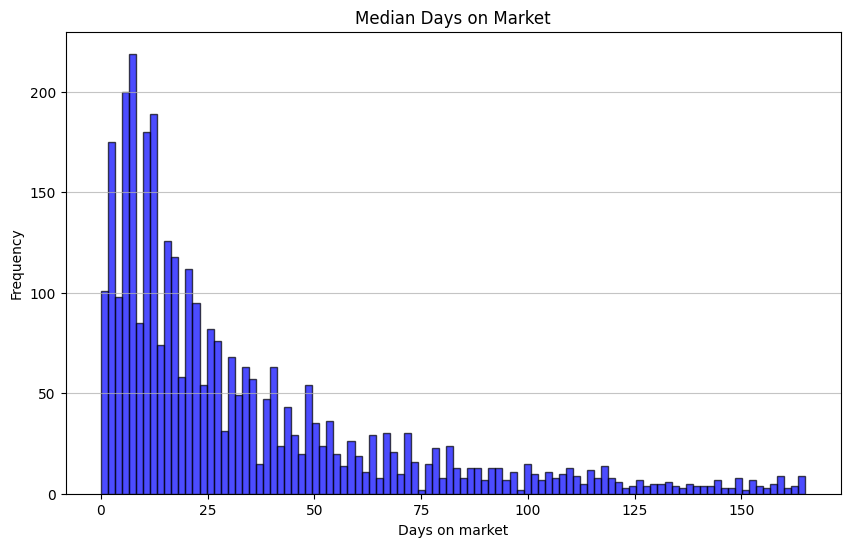

In [ ]:
#histogram of y_test
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=100, color='blue', alpha=0.7, edgecolor='black', range=(0, 165))
plt.title('Median Days on Market')
plt.xlabel('Days on market')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

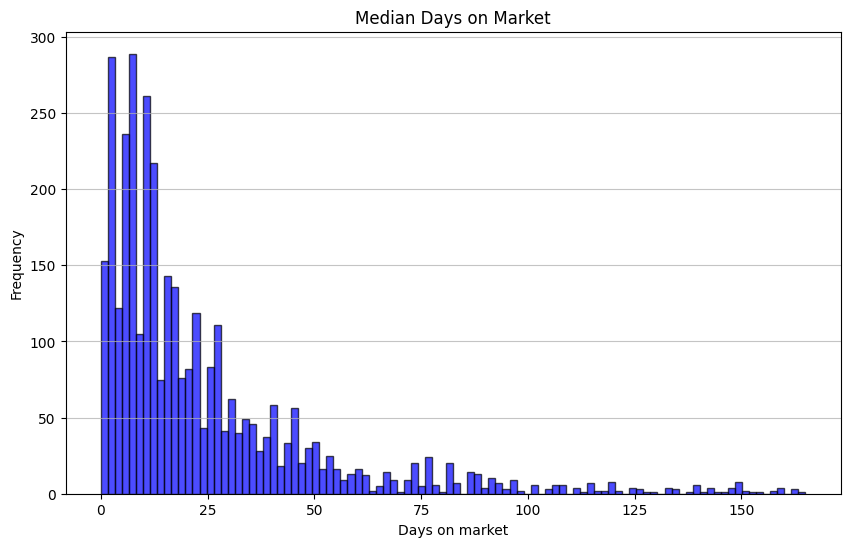

In [ ]:
#histogram of y_pred
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=100, color='blue', alpha=0.7, edgecolor='black', range=(0, 165))
plt.title('Median Days on Market')
plt.xlabel('Days on market')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

wrap code in a function

In [ ]:
def run_xg_experiment(df_data=df_data1,
                                  n_features=5,
                                  max_depth=1,
                                  n_estimators=152,
                                  learning_rate=0.4,
                                  subsample=0.83,
                                  test_size = 0.33
                                  ):

    """
    Runs XGBoost with cross-validation. Returns a dataframe with average training accuracies, average validation accuracies, and average variance across folds

    Params:
        df_data: main dataframe
        n_features: number of features
        max_depth: weak learner tree depth
        n_estimators: number of trees
        learning_rate: learning rate
        subsample:fraction of observations used for each tree

    Returns:
        df_results: dataframe with results of experiment
    """

    # Print number of features used
    print(f"\nRunning experiment with {n_features} features, n estimators={n_estimators}, learning rate={learning_rate}, max depth={max_depth}, subsample={subsample}")
    print("-----------------------------------------------------------------------------------------")

    # Calculate column index for last feature
    last_feature_index = n_features + 1

    # Split the data into X and y
    X = np.array(df_data.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_data.iloc[:, n_features])

    # Split between train and test
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=test_size, random_state=seed)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)

    # Define the evaluation procedure with k-fold cross-validation
    # k_folds = 5
    # cv = KFold(n_splits=k_folds, shuffle=True, random_state=1)

    # Create the logistic regression model with the best hyperparameters
    model = xgb.XGBClassifier(objective='multi:softprob',
                             max_depth=max_depth,
                             n_estimators=n_estimators,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             )

    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(accuracy)


    return accuracy

In [ ]:
# Run the experiment for n estimators hyperparameter and store results in df_results
for n_estimators in [100, 150, 300, 400]:
    df_result = run_xg_experiment(n_estimators = n_estimators)
df_result


Running experiment with 5 features, n estimators=100, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.5684624017957352

Running experiment with 5 features, n estimators=150, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.6234567901234568

Running experiment with 5 features, n estimators=300, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.835016835016835

Running experiment with 5 features, n estimators=400, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.845679012345679


0.845679012345679

In [ ]:
# Run the experiment for n estimators hyperparameter and store results in df_results
for learning_rate in [0.1, 0.5, 1.3, 1.8, 2.0]:
    df_result = run_xg_experiment(n_estimators = 400, learning_rate = learning_rate)
df_result


Running experiment with 5 features, n estimators=400, learning rate=0.1, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.8613916947250281

Running experiment with 5 features, n estimators=400, learning rate=0.5, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.7982603815937149

Running experiment with 5 features, n estimators=400, learning rate=1.3, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.55331088664422

Running experiment with 5 features, n estimators=400, learning rate=1.8, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
0.029461279461279462

Running experiment with 5 features, n estimators=400, learning rate=2.0, max depth=1, subsample=0.83
------------------------------------------------------

0.04040404040404041

implement k folding

In [ ]:
def run_xg_experiment(df_data=df_data1,
                                  n_features=6,
                                  max_depth=1,
                                  n_estimators=152,
                                  learning_rate=0.4,
                                  subsample=0.83
                                  ):

    """
    Runs XGBoost with cross-validation. Returns a dataframe with average training accuracies, average validation accuracies, and average variance across folds

    Params:
        df_data: main dataframe
        n_features: number of features
        max_depth: weak learner tree depth
        n_estimators: number of trees
        learning_rate: learning rate
        subsample:fraction of observations used for each tree

    Returns:
        df_results: dataframe with results of experiment
    """

    # Print number of features used
    print(f"\nRunning experiment with {n_features} features, n estimators={n_estimators}, learning rate={learning_rate}, max depth={max_depth}, subsample={subsample}")
    print("-----------------------------------------------------------------------------------------")

    # Calculate column index for last feature
    last_feature_index = n_features + 1

    # Split the data into X and y
    X = np.array(df_data.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_data.iloc[:, n_features])
    le = LabelEncoder()

    # Define the evaluation procedure with k-fold cross-validation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=1)

    # Create the logistic regression model with the best hyperparameters
    model = xgb.XGBClassifier(objective='multi:softprob',
                             max_depth=max_depth,
                             n_estimators=n_estimators,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             )
    # Lists to store training and validation scores for each fold
    train_MSEs = []
    validation_MSEs = []

    # Perform cross-validation and get training and validation scores for each fold
    for train_index, validation_index in cv.split(X_std, y):
        X_train, X_val = X_std[train_index], X_std[validation_index]
        y_train, y_val = le.fit_transform(y[train_index]), le.fit_transform(y[validation_index])

        # Train the model on the training set within each fold
        model.fit(X_train, y_train)

        # Calculate training and validation accuracies
        train_MSE = model.score(X_train, y_train)
        validation_MSE = model.score(X_val, y_val)

        # Append the accuracies to the lists
        train_MSEs.append(train_MSE)
        validation_MSEs.append(validation_MSE)

        # Print the accuracy for the current fold
        print(f"Fold {len(train_MSEs)} - Training Accuracy: {train_MSE:.4f}, Validation Accuracy: {validation_MSE:.4f}")

    # Calculate average training and validation accuracies
    average_training_MSE = np.mean(train_MSEs)
    average_validation_MSE = np.mean(validation_MSEs)
    average_variance = average_training_MSE - average_validation_MSE # Include as a measure of overfitting

    # Print the overall statistics
    print("Average Training Accuracy:", average_training_MSE)
    print("Average Validation Accuracy:", average_validation_MSE)

    # Create a dataframe containing results of the experiment
    df_results = pd.DataFrame({
        'n_features': [n_features],
        'n_estimators': [n_estimators],
        'learning rate': [learning_rate],
        'subsample': [subsample],
        'max_depth': [max_depth],
        'average_training_accuracy': [average_training_MSE],
        'average_validation_accuracy': [average_validation_MSE],
        'average_variance': [average_variance]
    })

    return df_results

In [ ]:
# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['n_features', 'n_estimators', 'learning rate', 'subsample', 'max_depth', 'average_training_MSE', 'average_validation_MSE', 'average_variance'])

In [ ]:
# Run the experiment for n estimators hyperparameter and store results in df_results
for n_estimators in [100, 150, 300, 400]:
    df_results = pd.concat([df_results, run_xg_experiment(n_estimators = n_estimators)], ignore_index=True)

df_results


Running experiment with 6 features, n estimators=100, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.5870, Validation Accuracy: 0.5574
Fold 2 - Training Accuracy: 0.5161, Validation Accuracy: 0.4329
Fold 3 - Training Accuracy: 0.4935, Validation Accuracy: 0.4606
Fold 4 - Training Accuracy: 0.4930, Validation Accuracy: 0.4528
Fold 5 - Training Accuracy: 0.4647, Validation Accuracy: 0.4284
Average Training Accuracy: 0.5108585554097911
Average Validation Accuracy: 0.46642855917520115

Running experiment with 6 features, n estimators=150, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.6706, Validation Accuracy: 0.6338
Fold 2 - Training Accuracy: 0.6468, Validation Accuracy: 0.5329
Fold 3 - Training Accuracy: 0.5796, Validation Accuracy: 0.5176
Fold 4 - 

,n_features,n_estimators,learning rate,subsample,max_depth,average_training_MSE,average_validation_MSE,average_variance,average_training_accuracy,average_validation_accuracy
0,6,100,0.4,0.83,1,NaN,NaN,0.044430,0.510859,0.466429
1,6,150,0.4,0.83,1,NaN,NaN,0.078714,0.636448,0.557734
2,6,300,0.4,0.83,1,NaN,NaN,0.137396,0.867742,0.730346
3,6,400,0.4,0.83,1,NaN,NaN,0.114940,0.857231,0.742291


In [ ]:
# Run the experiment for learning rate hyperparameter and store results in df_results
for learning_rate in [0.1, 0.5, 1.3, 1.8, 2.0]:
    df_results = pd.concat([df_results, run_xg_experiment(n_estimators = 300, learning_rate=learning_rate)], ignore_index=True)

df_results


Running experiment with 6 features, n estimators=300, learning rate=0.1, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.9661, Validation Accuracy: 0.8639
Fold 2 - Training Accuracy: 0.9646, Validation Accuracy: 0.8370
Fold 3 - Training Accuracy: 0.9671, Validation Accuracy: 0.8370
Fold 4 - Training Accuracy: 0.9642, Validation Accuracy: 0.8426
Fold 5 - Training Accuracy: 0.9668, Validation Accuracy: 0.8499
Average Training Accuracy: 0.9657606949321125
Average Validation Accuracy: 0.8460972157892028

Running experiment with 6 features, n estimators=300, learning rate=0.5, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8619, Validation Accuracy: 0.7810
Fold 2 - Training Accuracy: 0.9338, Validation Accuracy: 0.7968
Fold 3 - Training Accuracy: 0.7246, Validation Accuracy: 0.5921
Fold 4 - T

,n_features,n_estimators,learning rate,subsample,max_depth,average_training_MSE,average_validation_MSE,average_variance,average_training_accuracy,average_validation_accuracy
0,6,100,0.4,0.83,1,NaN,NaN,0.044430,0.510859,0.466429
1,6,150,0.4,0.83,1,NaN,NaN,0.078714,0.636448,0.557734
2,6,300,0.4,0.83,1,NaN,NaN,0.137396,0.867742,0.730346
3,6,400,0.4,0.83,1,NaN,NaN,0.114940,0.857231,0.742291
4,6,300,0.1,0.83,1,NaN,NaN,0.119663,0.965761,0.846097
5,6,300,0.5,0.83,1,NaN,NaN,0.115465,0.779034,0.663569
6,6,300,1.3,0.83,1,NaN,NaN,0.077984,0.427301,0.349317
7,6,300,1.8,0.83,1,NaN,NaN,0.017229,0.090751,0.073522
8,6,300,2.0,0.83,1,NaN,NaN,0.001366,0.033684,0.032317


## Adaboosting

In [ ]:
n_features=8
max_depth=1
n_estimators=152
learning_rate=0.4
subsample=0.83
test_size = 0.33
n_estimators=800

last_feature_index = n_features + 1

# Split the data into X and y
X = np.array(df_select.iloc[:, 0:n_features])
X_std = StandardScaler().fit_transform(X)
y = np.array(df_select.iloc[:, n_features])

# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=test_size, random_state=seed)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

# Create the logistic regression model with the best hyperparameters
base = DecisionTreeClassifier(max_depth=max_depth,criterion='entropy')
model = AdaBoostClassifier(
        estimator=base,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
    )

#train data
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = le.inverse_transform(y_pred)

# evaluate predictions
mse = mean_squared_error(y_test, predictions)
r2_score = r2_score(y_test, predictions)
print("MSE: %.2f%%" % mse)
print("R2_score: %.2f%%" % r2_score)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=1),
                   learning_rate=0.4, n_estimators=800)
MSE: 563.52%
R2_score: 0.45%


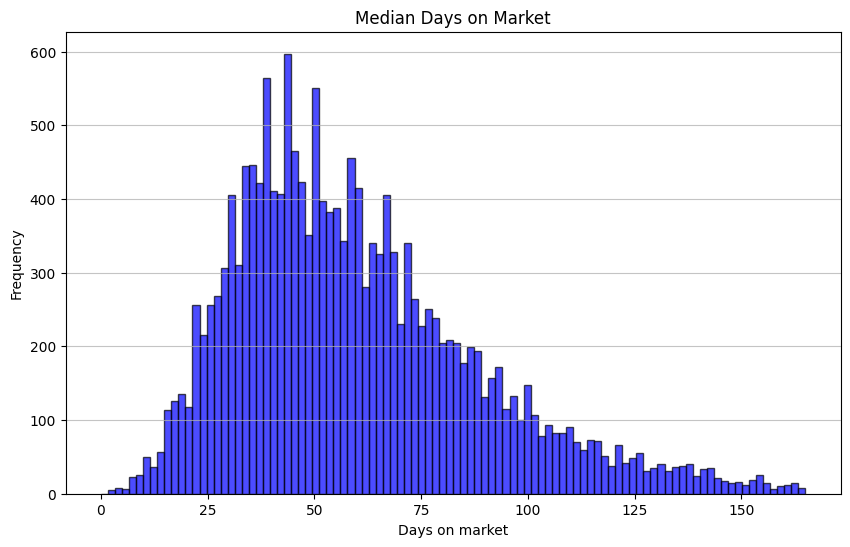

In [ ]:
#histogram of y_test
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=100, color='blue', alpha=0.7, edgecolor='black', range=(0, 165))
plt.title('Median Days on Market')
plt.xlabel('Days on market')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

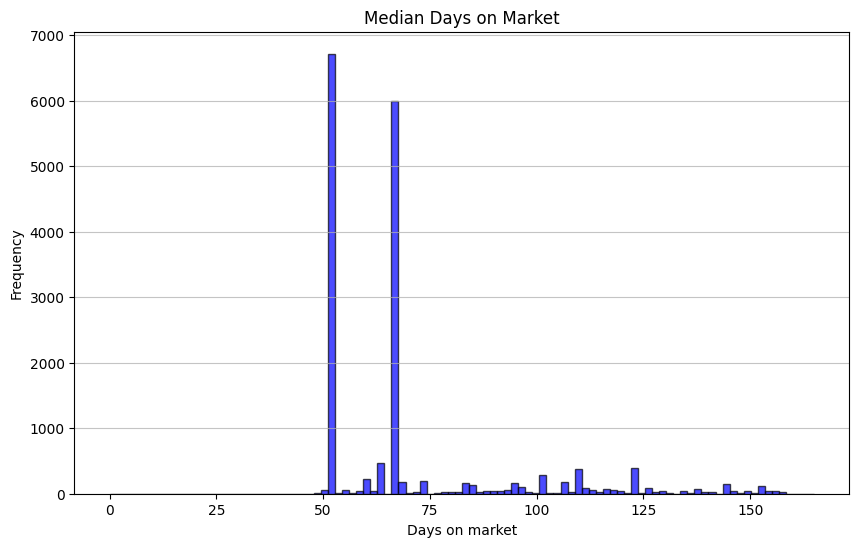

In [ ]:
#histogram of y_pred
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=100, color='blue', alpha=0.7, edgecolor='black', range=(0, 165))
plt.title('Median Days on Market')
plt.xlabel('Days on market')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()